#### Human activity classification with convolutional encoder feature representations

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

import torch
import torch.nn.functional as F

import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt import callbacks
from skopt.callbacks import CheckpointSaver

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sys.executable

'c:\\Users\\arthu\\AppData\\Local\\Programs\\Python\\Python311\\python.exe'

In [3]:

module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from enc_class_training_loop import train_and_save_conv_classifier
from frame_dataloader_heavy import WorkloadFrame
import utils

# if there is trouble installing modules: compare python paths used in notebooks vs cmd
# print(sys.executable)
# !python -c "import sys; print(sys.executable)"

# install modules to the currently used python path in cmd
#%pip install scikit-optimize
# OR
#"C:\path\to\your\jupyter\python.exe" -m pip install scikit-optimize

# check what env jupyter is using, install the correct one
# jupyter kernelspec list
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

# saving project requirements:
# pip freeze > requirements.txt
# pip install -r requirements.txt



#### Probing

Early stopping and learning rate heuristics

In [4]:
a = F.one_hot(torch.tensor(3), 5)
b = F.one_hot(torch.tensor(1), 5)
a, b

(tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]))

In [5]:
torch.argmax(a)

tensor(3)

In [6]:
s = pd.Series([1, 2, 3, 4, 5, 6,7])
x = s[-12:].values**2
y = np.arange(len(x))
grad = np.gradient(y, x)

grad

array([0.33333333, 0.28333333, 0.17619048, 0.12896825, 0.1020202 ,
       0.08449883, 0.07692308])

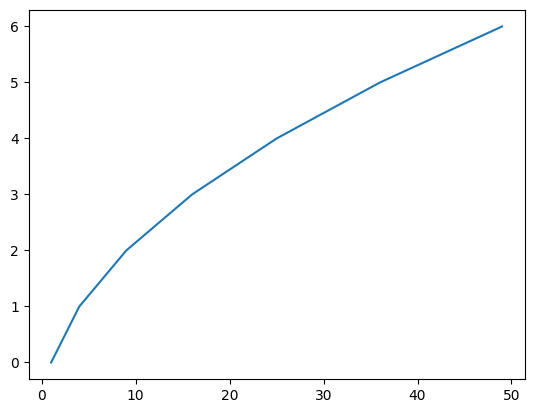

In [7]:
plt.plot(x, y)

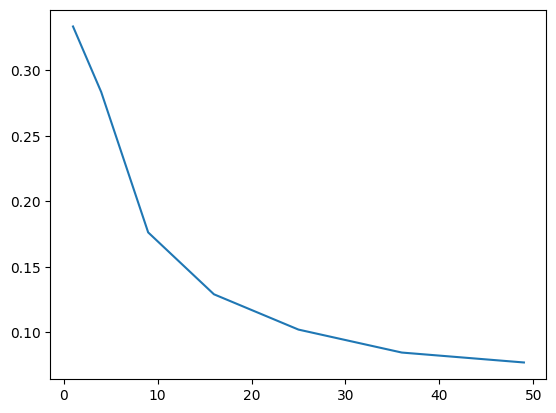

In [8]:
plt.plot(x, grad)

#### Bayesian Parameter Optimization

Finds objective Loss function of model hyperparameters 

- randomly samples parameter space via initial_point_generator for n_initialial_points
- observes function values and approximates function with gaussian prior
- updates prior based on observed values

The optimization result returned as a OptimizeResult object. Saved attributes are:
```
x [list]: location of the minimum.

fun [float]: function value at the minimum.

x_iters [list of lists]: location of function evaluation for each iteration.

func_vals [array]: function value for each iteration.

space [Space]: the optimization space

specs [dict]`: the call specifications.

rng [RandomState instance]: State of the random state at the end of minimization.
```
For more details related to the OptimizeResult object, see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)

for more, see [Documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize)

In [4]:
param_space = [
    Integer(16,  128, name='hidden_dim'), # hidden layer dimension
    Integer(16,  128, name='latent_dim'), # latent dimension
    #Integer(1, 4, name='conv_blocks'), # number of convolutional blocks
    Integer(4, 32, name='init_channel') # initial channel size 
]

# trainig epochs must stay same if optim run is interrupted to prevent skewing of loss landscape
optim_name = 'BayesOpt2Error'
save_filepath = "..\\saved_models\\classifier\\bayes_opt2\\"
training_epochs = 101


file_dir='..\\files'
#  file group: 'phys', 'cog', or 'tot'
group='phys'
# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'
# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5
frames = WorkloadFrame(dir=file_dir, group=group, resample=resample, context_length=context_length)

checkpoint_saver = CheckpointSaver(save_filepath+optim_name+'.pkl', compress=9)

def objective_error(x):
    hdim, ldim, initc = x
    hdim, ldim, initc = int(hdim), int(ldim), int(initc)

    print(f'Evaluation point: \n hdim {hdim} ldim {ldim} initc {initc}')

    config = {'latent_dim':ldim, 'conv_blocks':[1, initc], 'hidden_dim':hdim, 'kernel':(3, 2), 'id':optim_name}
    try:
        accuracy = train_and_save_conv_classifier(config=config, num_epochs=training_epochs, save_filepath=save_filepath, dataset=frames)
    except Exception as e:
        print(f'Trianing failed {e}')
    error = 1-accuracy
    print(f'Achieved final error of {error}')
    return error

result = gp_minimize(
    objective_error, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=30, # how often function is observed
    n_initial_points=30, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    callback=[checkpoint_saver],
    noise=1e-10
)


Iteration No: 1 started. Evaluating function at random point.
Evaluation point: 
 hdim 41 ldim 52 initc 31
Using 4 workers (CPU cores: 8, Available RAM: 2.05GB)


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.420795202255249
No saved weights found for conv_classifier_ldim52_convblocks2_hdim41_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim52_convblocks2_hdim41_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim52_convblocks2_hdim41_kernel(3, 2)_idBayesOpt2Error')


Model trained for 100 epochs. Saved data for conv_classifier_ldim52_convblocks2_hdim41_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9791666666666666
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 323.5546
Function value obtained: 0.9792
Current minimum: 0.9792
Iteration No: 2 started. Evaluating function at random point.
Evaluation point: 
 hdim 67 ldim 50 initc 11
Using 4 workers (CPU cores: 8, Available RAM: 2.03GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3959732055664062
No saved weights found for conv_classifier_ldim50_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim50_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim50_conv

Model trained for 100 epochs. Saved data for conv_classifier_ldim50_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 76.1093
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 3 started. Evaluating function at random point.
Evaluation point: 
 hdim 26 ldim 63 initc 4
Using 4 workers (CPU cores: 8, Available RAM: 2.96GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3916414976119995
No saved weights found for conv_classifier_ldim63_convblocks2_hdim26_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim63_convblocks2_hdim26_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim63_convblocks2_hdim26

Model trained for 100 epochs. Saved data for conv_classifier_ldim63_convblocks2_hdim26_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 1.0
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 72.0817
Function value obtained: 1.0000
Current minimum: 0.9375
Iteration No: 4 started. Evaluating function at random point.
Evaluation point: 
 hdim 75 ldim 113 initc 13
Using 4 workers (CPU cores: 8, Available RAM: 3.44GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.363577127456665
No saved weights found for conv_classifier_ldim113_convblocks2_hdim75_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim113_convblocks2_hdim75_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim113_convblocks2_hdim7

Model trained for 100 epochs. Saved data for conv_classifier_ldim113_convblocks2_hdim75_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9791666666666666
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 70.7170
Function value obtained: 0.9792
Current minimum: 0.9375
Iteration No: 5 started. Evaluating function at random point.
Evaluation point: 
 hdim 60 ldim 92 initc 23
Using 4 workers (CPU cores: 8, Available RAM: 3.78GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3959193229675293
No saved weights found for conv_classifier_ldim92_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim92_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim92_conv

Model trained for 100 epochs. Saved data for conv_classifier_ldim92_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 71.4308
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 6 started. Evaluating function at random point.
Evaluation point: 
 hdim 94 ldim 55 initc 30
Using 4 workers (CPU cores: 8, Available RAM: 3.72GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3948458433151245
No saved weights found for conv_classifier_ldim55_convblocks2_hdim94_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim55_convblocks2_hdim94_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim55_convb

Model trained for 100 epochs. Saved data for conv_classifier_ldim55_convblocks2_hdim94_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 324.3538
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 7 started. Evaluating function at random point.
Evaluation point: 
 hdim 45 ldim 100 initc 11
Using 4 workers (CPU cores: 8, Available RAM: 3.59GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.386432409286499
No saved weights found for conv_classifier_ldim100_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim100_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim100_c

Model trained for 100 epochs. Saved data for conv_classifier_ldim100_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9791666666666666
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 77.7265
Function value obtained: 0.9792
Current minimum: 0.9375
Iteration No: 8 started. Evaluating function at random point.
Evaluation point: 
 hdim 111 ldim 35 initc 26
Using 4 workers (CPU cores: 8, Available RAM: 3.26GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.390566110610962
No saved weights found for conv_classifier_ldim35_convblocks2_hdim111_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim35_convblocks2_hdim111_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim35_co

Model trained for 100 epochs. Saved data for conv_classifier_ldim35_convblocks2_hdim111_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 78.4593
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 9 started. Evaluating function at random point.
Evaluation point: 
 hdim 121 ldim 66 initc 15
Using 4 workers (CPU cores: 8, Available RAM: 3.04GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3994611501693726
No saved weights found for conv_classifier_ldim66_convblocks2_hdim121_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim66_convblocks2_hdim121_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim66_convblocks2_h

Model trained for 100 epochs. Saved data for conv_classifier_ldim66_convblocks2_hdim121_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 73.1256
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 10 started. Evaluating function at random point.
Evaluation point: 
 hdim 56 ldim 38 initc 7
Using 4 workers (CPU cores: 8, Available RAM: 3.51GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3799793720245361
No saved weights found for conv_classifier_ldim38_convblocks2_hdim56_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim38_convblocks2_hdim56_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim38_convblocks2_hdim

Model trained for 100 epochs. Saved data for conv_classifier_ldim38_convblocks2_hdim56_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 68.0405
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 11 started. Evaluating function at random point.
Evaluation point: 
 hdim 70 ldim 85 initc 31
Using 4 workers (CPU cores: 8, Available RAM: 3.64GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3853802680969238
No saved weights found for conv_classifier_ldim85_convblocks2_hdim70_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim85_convblocks2_hdim70_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim85_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim85_convblocks2_hdim70_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 307.4498
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 12 started. Evaluating function at random point.
Evaluation point: 
 hdim 55 ldim 47 initc 17
Using 4 workers (CPU cores: 8, Available RAM: 3.11GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3908432722091675
No saved weights found for conv_classifier_ldim47_convblocks2_hdim55_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim47_convblocks2_hdim55_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim47_convblocks2_hd

Model trained for 100 epochs. Saved data for conv_classifier_ldim47_convblocks2_hdim55_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 73.6139
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 13 started. Evaluating function at random point.
Evaluation point: 
 hdim 123 ldim 36 initc 8
Using 4 workers (CPU cores: 8, Available RAM: 3.02GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3835935592651367
No saved weights found for conv_classifier_ldim36_convblocks2_hdim123_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim36_convblocks2_hdim123_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim36_convblocks2_h

Model trained for 100 epochs. Saved data for conv_classifier_ldim36_convblocks2_hdim123_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 70.5692
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 14 started. Evaluating function at random point.
Evaluation point: 
 hdim 25 ldim 77 initc 13
Using 4 workers (CPU cores: 8, Available RAM: 3.48GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3776109218597412
No saved weights found for conv_classifier_ldim77_convblocks2_hdim25_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim77_convblocks2_hdim25_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim77_convblocks2_hd

Model trained for 100 epochs. Saved data for conv_classifier_ldim77_convblocks2_hdim25_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9791666666666666
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 68.6398
Function value obtained: 0.9792
Current minimum: 0.9375
Iteration No: 15 started. Evaluating function at random point.
Evaluation point: 
 hdim 48 ldim 119 initc 16
Using 4 workers (CPU cores: 8, Available RAM: 3.49GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.385575771331787
No saved weights found for conv_classifier_ldim119_convblocks2_hdim48_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim119_convblocks2_hdim48_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim119_

Model trained for 100 epochs. Saved data for conv_classifier_ldim119_convblocks2_hdim48_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 68.3870
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 16 started. Evaluating function at random point.
Evaluation point: 
 hdim 63 ldim 126 initc 26
Using 4 workers (CPU cores: 8, Available RAM: 3.61GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3911895751953125
No saved weights found for conv_classifier_ldim126_convblocks2_hdim63_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim126_convblocks2_hdim63_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim126_convblocks

Model trained for 100 epochs. Saved data for conv_classifier_ldim126_convblocks2_hdim63_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 68.8701
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 17 started. Evaluating function at random point.
Evaluation point: 
 hdim 54 ldim 50 initc 18
Using 4 workers (CPU cores: 8, Available RAM: 3.71GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4039382934570312
No saved weights found for conv_classifier_ldim50_convblocks2_hdim54_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim50_convblocks2_hdim54_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim50_convblocks2_hd

Model trained for 100 epochs. Saved data for conv_classifier_ldim50_convblocks2_hdim54_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 66.3641
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 18 started. Evaluating function at random point.
Evaluation point: 
 hdim 86 ldim 90 initc 11
Using 4 workers (CPU cores: 8, Available RAM: 3.52GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3795247077941895
No saved weights found for conv_classifier_ldim90_convblocks2_hdim86_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim90_convblocks2_hdim86_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim90_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim90_convblocks2_hdim86_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 66.0811
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 19 started. Evaluating function at random point.
Evaluation point: 
 hdim 61 ldim 91 initc 16
Using 4 workers (CPU cores: 8, Available RAM: 3.46GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3781319856643677
No saved weights found for conv_classifier_ldim91_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim91_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim91_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim91_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 66.1942
Function value obtained: 0.9583
Current minimum: 0.9375
Iteration No: 20 started. Evaluating function at random point.
Evaluation point: 
 hdim 104 ldim 93 initc 25
Using 4 workers (CPU cores: 8, Available RAM: 3.56GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3882341384887695
No saved weights found for conv_classifier_ldim93_convblocks2_hdim104_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim93_convblocks2_hdim104_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim93_

Model trained for 100 epochs. Saved data for conv_classifier_ldim93_convblocks2_hdim104_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 69.4023
Function value obtained: 0.9375
Current minimum: 0.9375
Iteration No: 21 started. Evaluating function at random point.
Evaluation point: 
 hdim 71 ldim 123 initc 8
Using 4 workers (CPU cores: 8, Available RAM: 3.50GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.392174482345581
No saved weights found for conv_classifier_ldim123_convblocks2_hdim71_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim123_convblocks2_hdim71_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim123_convblocks2_

Model trained for 100 epochs. Saved data for conv_classifier_ldim123_convblocks2_hdim71_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9166666666666666
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 69.2104
Function value obtained: 0.9167
Current minimum: 0.9167
Iteration No: 22 started. Evaluating function at random point.
Evaluation point: 
 hdim 89 ldim 78 initc 28
Using 4 workers (CPU cores: 8, Available RAM: 3.58GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3753389120101929
No saved weights found for conv_classifier_ldim78_convblocks2_hdim89_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim78_convblocks2_hdim89_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim78_co

Model trained for 100 epochs. Saved data for conv_classifier_ldim78_convblocks2_hdim89_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 69.2167
Function value obtained: 0.9583
Current minimum: 0.9167
Iteration No: 23 started. Evaluating function at random point.
Evaluation point: 
 hdim 32 ldim 66 initc 22
Using 4 workers (CPU cores: 8, Available RAM: 3.46GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3870364427566528
No saved weights found for conv_classifier_ldim66_convblocks2_hdim32_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim66_convblocks2_hdim32_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim66_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim66_convblocks2_hdim32_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 65.4109
Function value obtained: 0.9375
Current minimum: 0.9167
Iteration No: 24 started. Evaluating function at random point.
Evaluation point: 
 hdim 90 ldim 110 initc 19
Using 4 workers (CPU cores: 8, Available RAM: 3.65GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4109578132629395
No saved weights found for conv_classifier_ldim110_convblocks2_hdim90_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim110_convblocks2_hdim90_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim110_convblocks2

Model trained for 100 epochs. Saved data for conv_classifier_ldim110_convblocks2_hdim90_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 65.3674
Function value obtained: 0.9583
Current minimum: 0.9167
Iteration No: 25 started. Evaluating function at random point.
Evaluation point: 
 hdim 20 ldim 27 initc 26
Using 4 workers (CPU cores: 8, Available RAM: 3.65GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3781297206878662
No saved weights found for conv_classifier_ldim27_convblocks2_hdim20_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim27_convblocks2_hdim20_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim27_co

Model trained for 100 epochs. Saved data for conv_classifier_ldim27_convblocks2_hdim20_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 70.5868
Function value obtained: 0.9583
Current minimum: 0.9167
Iteration No: 26 started. Evaluating function at random point.
Evaluation point: 
 hdim 61 ldim 92 initc 18
Using 4 workers (CPU cores: 8, Available RAM: 3.57GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4076435565948486
No saved weights found for conv_classifier_ldim92_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim92_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim92_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim92_convblocks2_hdim61_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9166666666666666
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 66.7893
Function value obtained: 0.9167
Current minimum: 0.9167
Iteration No: 27 started. Evaluating function at random point.
Evaluation point: 
 hdim 60 ldim 104 initc 31
Using 4 workers (CPU cores: 8, Available RAM: 3.34GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.38413667678833
No saved weights found for conv_classifier_ldim104_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim104_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim104_c

Model trained for 100 epochs. Saved data for conv_classifier_ldim104_convblocks2_hdim60_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 302.2210
Function value obtained: 0.9375
Current minimum: 0.9167
Iteration No: 28 started. Evaluating function at random point.
Evaluation point: 
 hdim 45 ldim 74 initc 28
Using 4 workers (CPU cores: 8, Available RAM: 3.54GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3897088766098022
No saved weights found for conv_classifier_ldim74_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim74_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim74_convblocks2_h

Model trained for 100 epochs. Saved data for conv_classifier_ldim74_convblocks2_hdim45_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9375
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 77.9243
Function value obtained: 0.9375
Current minimum: 0.9167
Iteration No: 29 started. Evaluating function at random point.
Evaluation point: 
 hdim 67 ldim 28 initc 26
Using 4 workers (CPU cores: 8, Available RAM: 3.54GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.4066153764724731
No saved weights found for conv_classifier_ldim28_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim28_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim28_convblocks2_hdi

Model trained for 100 epochs. Saved data for conv_classifier_ldim28_convblocks2_hdim67_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 71.9293
Function value obtained: 0.9583
Current minimum: 0.9167
Iteration No: 30 started. Evaluating function at random point.
Evaluation point: 
 hdim 72 ldim 38 initc 29
Using 4 workers (CPU cores: 8, Available RAM: 3.80GB)
Modell initialised. Shapes: 
 torch.Size([64, 1, 129, 5]) torch.Size([64, 4]) 1.3890928030014038
No saved weights found for conv_classifier_ldim38_convblocks2_hdim72_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\
No existing log data found for conv_classifier_ldim38_convblocks2_hdim72_kernel(3, 2)_idBayesOpt2Error in ..\saved_models\classifier\bayes_opt2\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\classifier\\bayes_opt2\\', 'conv_classifier_ldim38_con

Model trained for 100 epochs. Saved data for conv_classifier_ldim38_convblocks2_hdim72_kernel(3, 2)_idBayesOpt2Error
Achieved final error of 0.9583333333333334
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 286.3032
Function value obtained: 0.9583
Current minimum: 0.9167


In [150]:
# results
res = skopt.load(save_filepath+optim_name+'.pkl')
print(f'Hyperparameter space [hdim, ldim, init]: \n {res.space}')
print(f'Best hyperparameters: {res.x}')
print(f'Best objective function value: {res.fun}')
worst_index = np.argmax(result.func_vals)
print(f'Worst Hyperparameters: {res.x_iters[worst_index]}')
print(f'Worst objective function value: {res.func_vals[worst_index]}')

Hyperparameter space [hdim, ldim, init]: 
 Space([Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=16, high=128, prior='uniform', transform='normalize'),
       Integer(low=4, high=32, prior='uniform', transform='normalize')])
Best hyperparameters: [np.int64(45), np.int64(100), np.int64(11)]
Best objective function value: 0.4375
Worst Hyperparameters: [np.int64(123), np.int64(96), np.int64(6)]
Worst objective function value: 0.8541666666666666


In [ ]:
# launches tensorboard at localhost:6006
%reload_ext tensorboard
%tensorboard --logdir=..\\saved_models\\classifier\\bayes_opt2\\tensorboard_logs

Reusing TensorBoard on port 6007 (pid 19396), started 0:00:41 ago. (Use '!kill 19396' to kill it.)

In [ ]:
# remove tensorboard logs from optimization
!rd /s /q f"{save_filepath}tensorboard_logs\\"

The system cannot find the file specified.


#### Hyperparameter Analysis

In [243]:
best_model_name = 'conv_classifier_ndim96_convblocks2_hdim123_kernel(3, 2)_idBayesOpt1Accuracy'

In [ ]:
res = skopt.load(save_filepath+optim_name+'.pkl')

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

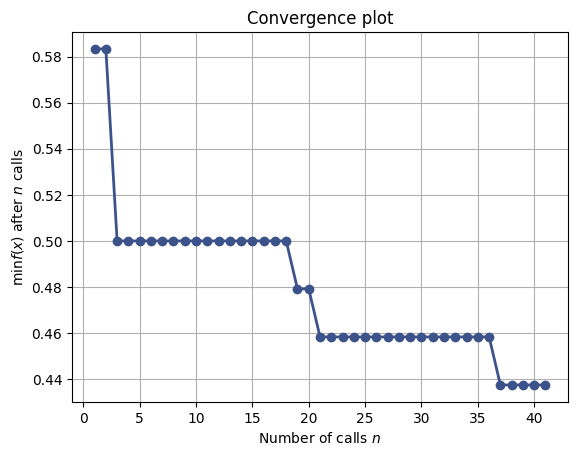

In [ ]:
skopt.plots.plot_convergence(res)

AssertionError: Space dimension must be 1

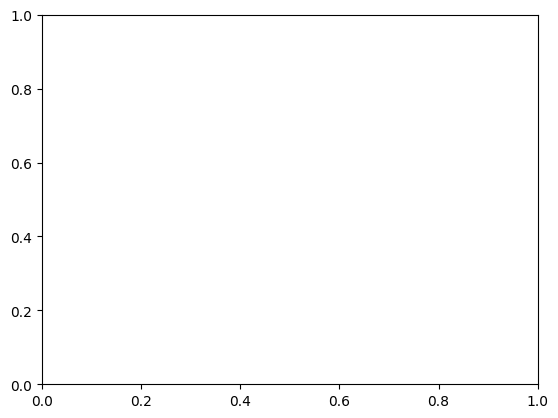

In [ ]:
skopt.plots.plot_gaussian_process(res)

<Axes: >

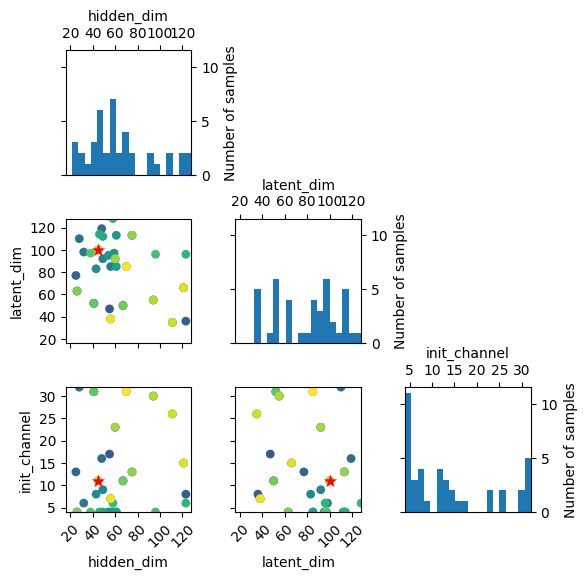

In [287]:
skopt.plots.plot_evaluations(res)

In [290]:
skopt.plots.plot_objective_2D(res, dimension_identifier1='hidden_dim', dimension_identifier2='latent_dim')

IndexError: list index out of range

#### Training Heuristics

In [291]:
best_model_loss = pd.read_csv(save_filepath+best_model_name+'.csv')

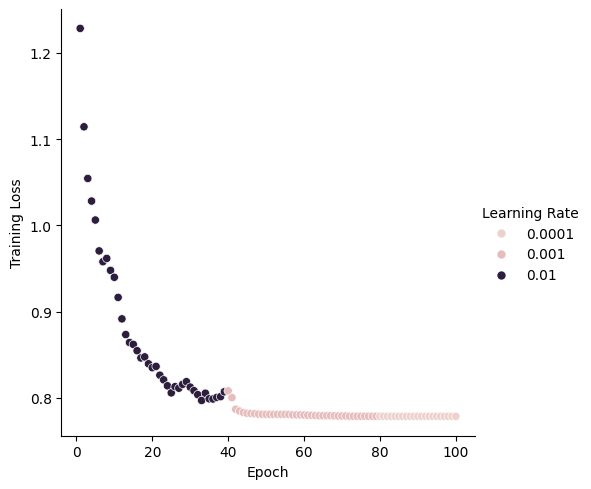

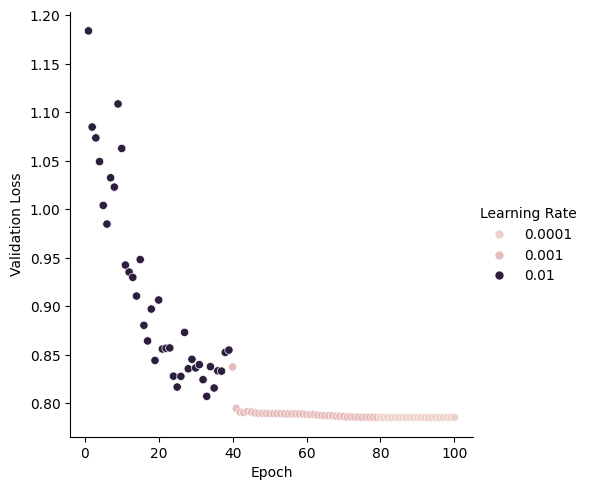

In [245]:
sns.relplot(data=best_model_loss, x='Epoch', y='Training Loss', hue='Learning Rate')
sns.relplot(data=best_model_loss, x='Epoch', y='Validation Loss', hue='Learning Rate')

In [264]:
def stopping_criterion(df, window_size):
    window_size = window_size
    sum_grad_ratios, mean_grad_ratios, var_grad_ratios = np.array([]), np.array([]), np.array([])
    for i in range(window_size, len(df)):
        loss_data = df.loc[i-window_size:i]
        past_train_loss = loss_data['Training Loss'].values
        past_val_loss = loss_data['Validation Loss'].values

        local_x = np.arange(len(past_train_loss))

        train_grad = np.gradient(past_train_loss, local_x)
        val_grad = np.gradient(past_val_loss, local_x)

        grad_ratio = -(train_grad / (val_grad + 1e-6))

        sum_grad_ratios=np.append(sum_grad_ratios, np.sum(grad_ratio))
        mean_grad_ratios=np.append(mean_grad_ratios, np.mean(grad_ratio))
        var_grad_ratios=np.append(var_grad_ratios, np.var(grad_ratio))
    return sum_grad_ratios, mean_grad_ratios, var_grad_ratios

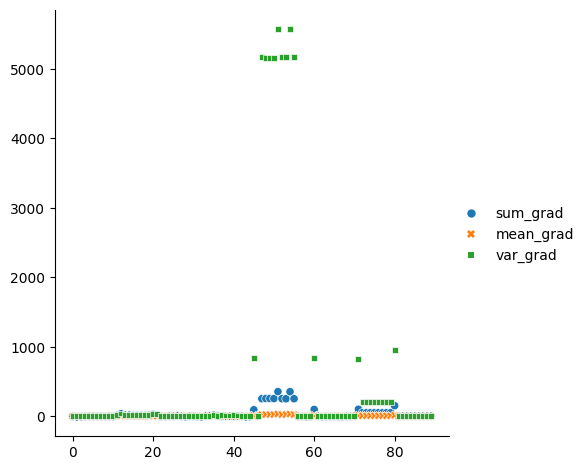

In [270]:
sum_grad_ratios, mean_grad_ratios, var_grad_ratios = stopping_criterion(df=best_model_loss, window_size=10)

sns.relplot(data={'sum_grad':sum_grad_ratios, 'mean_grad':mean_grad_ratios, 'var_grad':var_grad_ratios})

#### Animation creation

In [217]:
t0 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00000/Embeddings_epoch_0/tensors.tsv"), sep='\t').values
t1 = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/tensors.tsv"), sep='\t').values
labels = pd.read_csv(os.path.join(save_filepath, 'tensorboard_logs', best_model_name, "00050/Embeddings_epoch_50/metadata.tsv"), sep='\t').values
labels = np.array([int(s[7]) for s in labels[:, 0]])
t0.shape, t1.shape, labels

((3046, 96), (3046, 96), array([2, 0, 3, ..., 1, 3, 1]))

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [ ]:
tsne0 = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
t0_tsne = tsne0.fit_transform(t0)

tsne1 = TSNE(n_components=2, perplexity=30, n_iter=1200, random_state=42)
t1_tsne = tsne1.fit_transform(t1)

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


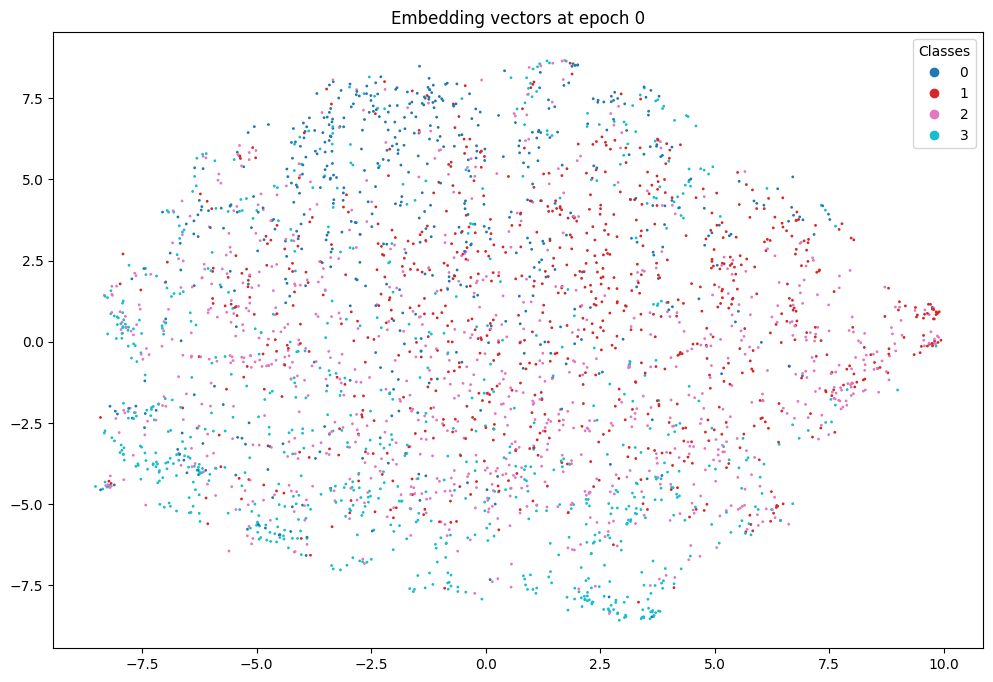

In [141]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t0_tsne[:, 0], t0_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 0')
plt.show()

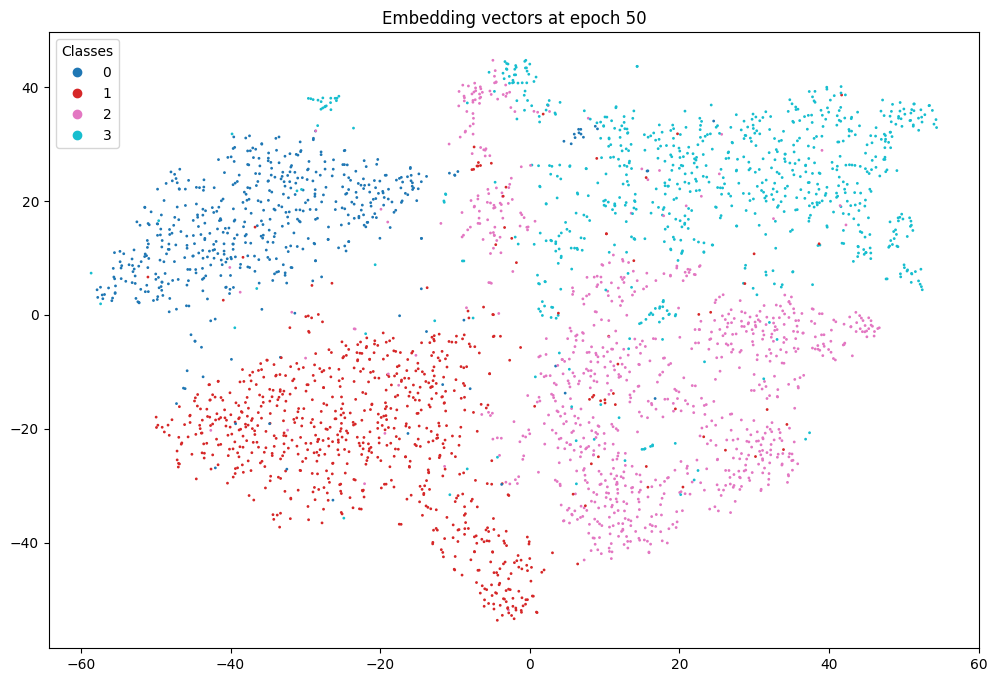

In [142]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(t1_tsne[:, 0], t1_tsne[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Embedding vectors at epoch 50')
plt.show()

#### Classification head

Train classification head on encoded feature representations, backpropagate through encoder aswell

In [ ]:
# load pretrained conv_ae

conv_ae_2 = ConvAE2d()
conv_ae_2.load_state_dict(torch.load('path_to_model/conv_ae.pth'))
conv_ae_2.eval()

# freeze all layers
for param in conv_ae.parameters():
    param.requires_grad = False  

# change last fc layers
num_features = conv_ae_2.fc.in_features
conv_ae_2.fc = nn.Linear(num_features, new_num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_ae_2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(conv_ae_2.fc.parameters(), lr=1e-3)  # only train last layer
criterion = nn.CrossEntropyLoss()
